## CS5850 Final Project Code by Gavin Murdock

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy.stats import pearsonr
from sklearn import tree
from sklearn.inspection import permutation_importance

### Combine datasets to show rookie stats and whether a player had a career lasting at least 5 years

In [68]:
rookie_stats = pd.read_csv('./NBA Rookies by Year.csv')
rookie_stats.rename(columns={'Name':'Player'}, inplace=True)

years_played = pd.read_csv('./NBA Players by State.csv')
years_played = years_played[['Player', 'Yrs']]
# this removes the many extra rows of completely NaN values
years_played.dropna(axis=0, inplace=True)

def five_yrs(yrs):
    if int(yrs) < 5:
        return 0
    else:
        return 1

data = rookie_stats.merge(years_played, on='Player', how='inner')
data = data.drop('Player', axis=1)

# change yrs to 0 for less than 5 years and 1 for more than 5 years in order to do binary classification
data['Yrs'] = data['Yrs'].apply(lambda yrs: five_yrs(yrs))

# for players who played before 3 point shots, change '-' in 3P% to 0
data['3P%'] = data['3P%'].apply(lambda threes: 0 if threes == '-' else threes)
data = data.astype({'3P%': float})

data.sample(5)

,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,Yrs
776,1992,77,35.6,15.4,5.8,12.6,46.4,0.9,2.6,36.9,...,74.6,1.0,2.5,3.5,3.8,1.6,0.7,2.6,14.7,1
125,2012,47,12.3,3.3,1.3,3.5,36.8,0.3,0.8,37.8,...,58.8,0.2,0.8,1.0,0.7,0.3,0.0,0.6,2.2,0
1021,1987,36,6.3,1.3,0.5,1.3,37.5,0.1,0.2,28.6,...,61.5,0.1,0.3,0.4,0.6,0.2,0.0,0.5,1.1,1
736,1994,38,6.5,3.1,1.2,3.0,39.5,0.5,1.5,31.0,...,66.7,0.2,0.4,0.6,1.1,0.3,0.1,0.7,2.5,0
866,1990,76,22.6,6.9,2.8,5.4,50.8,0.0,0.0,0.0,...,63.6,1.9,3.3,5.1,0.9,0.6,1.9,1.3,10.8,1


### Check if classes are too imbalanced

In [69]:
print('# of players with at least 5 year careers: ', len(data[data.Yrs == 0]))
print('# of players with less than 5 year careers: ', len(data[data.Yrs == 1]))

# of players with at least 5 year careers:  490
# of players with less than 5 year careers:  795


In [196]:
len(data)

1285

### create training and testing sets

In [70]:
X = data.drop('Yrs', axis=1)
Y = data.Yrs

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Standardize data

In [71]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Visualize standardized data

In [218]:
standardized = X_train.copy()
standardized_df = pd.DataFrame(standardized, columns=['Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'EFF'])
pd.set_option('display.max_columns', None)
display(standardized_df.head(3))

# standardized_y = y_train.copy()
# standardized_y_df = pd.DataFrame(standardized_y, columns=['Yrs'])
# standardized_y_df.head(3)

,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF
0,-0.849298,0.107273,-1.076585,-0.954533,-0.954100,-1.089941,1.211006,-0.664860,-0.758268,-1.232828,-0.702844,-0.611638,-0.511850,-0.116544,-0.373715,-0.289393,-0.998863,-0.781721,1.117691,-0.952998,-0.638194
1,-0.183914,-0.646852,-1.183498,-1.138319,-1.131601,-1.117398,-1.389432,-0.664860,-0.569436,0.177821,-0.806789,-0.844801,0.429138,-0.500132,-0.744758,-0.679360,-0.860495,-1.028303,-0.394465,-1.230883,-1.077238
2,-0.469079,0.977416,2.142689,1.986053,1.885925,1.847943,0.399404,1.667824,1.696551,1.111899,1.480006,1.486832,0.391498,0.011319,0.368373,0.246812,1.560951,2.423839,0.865665,1.964790,1.622882


### Look at varialbe correlation with target class

In [180]:
def print_correlation(data):
    print('{col:^12} | {corr:^20} | {p:^24}'.format(col='Column', corr='Correlation', p='P-Value'))
    for col in data.columns:
        if col == 'Yrs':
            continue
        corr, pvalue = pearsonr(data[col], data['Yrs'])
        print('{col:<12} | {corr:<20}'.format(col=col, corr=corr), '| ', pvalue)

print_correlation(data)

   Column    |     Correlation      |         P-Value         
Year Drafted | -0.1400660126640122  |  4.633139272943828e-07
GP           | 0.3911947281748093   |  3.0181966394803226e-48
MIN          | 0.3109098046749413   |  3.381136514696802e-30
PTS          | 0.30979923955374455  |  5.534927199988265e-30
FGM          | 0.31122312370600724  |  2.9410872965635354e-30
FGA          | 0.2857387811621094   |  1.4416068254192578e-25
FG%          | 0.21935362075136491  |  1.827260733040309e-15
3P Made      | 0.04227360152533593  |  0.1298788712360728
3PA          | 0.02444613230881252  |  0.3812497030523001
3P%          | 0.004487985714529151 |  0.8723103125296598
FTM          | 0.2913043805629553   |  1.494908731261937e-26
FTA          | 0.2901330845060283   |  2.4187247858203797e-26
FT%          | 0.10566483975527832  |  0.00014782342492115062
OREB         | 0.28547808317040224  |  1.6010634671213757e-25
DREB         | 0.28220010066979534  |  5.931842916576116e-25
REB          | 0.29528830

### Find best hyperparameters for logistic regression

In [85]:
lr = LogisticRegression()

params_lr = {
    'C':[1.0, 0.75, 0.5, 0.1, 0.01, 0.001], 
    'class_weight':['balanced', None], 
    'solver':['lbfgs', 'liblinear'], 
    'max_iter':[100, 150, 200, 250, 300, 500]
}

grid_search_lr = GridSearchCV(estimator=lr, param_grid=params_lr, cv=10, n_jobs=-1, scoring='f1')
grid_search_lr.fit(X_train, y_train)

lr_best = grid_search_lr.best_estimator_
lr_best

LogisticRegression(C=0.1)

In [86]:
lr_best.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [216]:
print('min average f1 score for LR: ', np.min(grid_search_lr.cv_results_['mean_test_score']))
print('max average f1 score for LR: ', np.max(grid_search_lr.cv_results_['mean_test_score']))

min average test score for LR:  0.6895471429008299
max average test score for LR:  0.7757856907966667


### Find best hyperparameters for decision tree

In [106]:
dt = DecisionTreeClassifier()

params_dt = {
    'criterion':['gini', 'entropy'], 
    'max_depth':[10, 15, 20, 30, 40, None], 
    'min_samples_split':[2, 10, 50, 100], 
    'min_samples_leaf':[1, 10, 20, 50, 100]
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=params_dt, cv=10, n_jobs=-1, scoring='f1')
grid_search_dt.fit(X_train, y_train)

dt_best = grid_search_dt.best_estimator_
dt_best

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=50)

In [107]:
dt_best.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [217]:
print('min average f1 score for DT: ', np.min(grid_search_dt.cv_results_['mean_test_score']))
print('max average f1 score for DT: ', np.max(grid_search_dt.cv_results_['mean_test_score']))

min average test score for DT:  0.7052907448234957
max average test score for DT:  0.7758805494485483


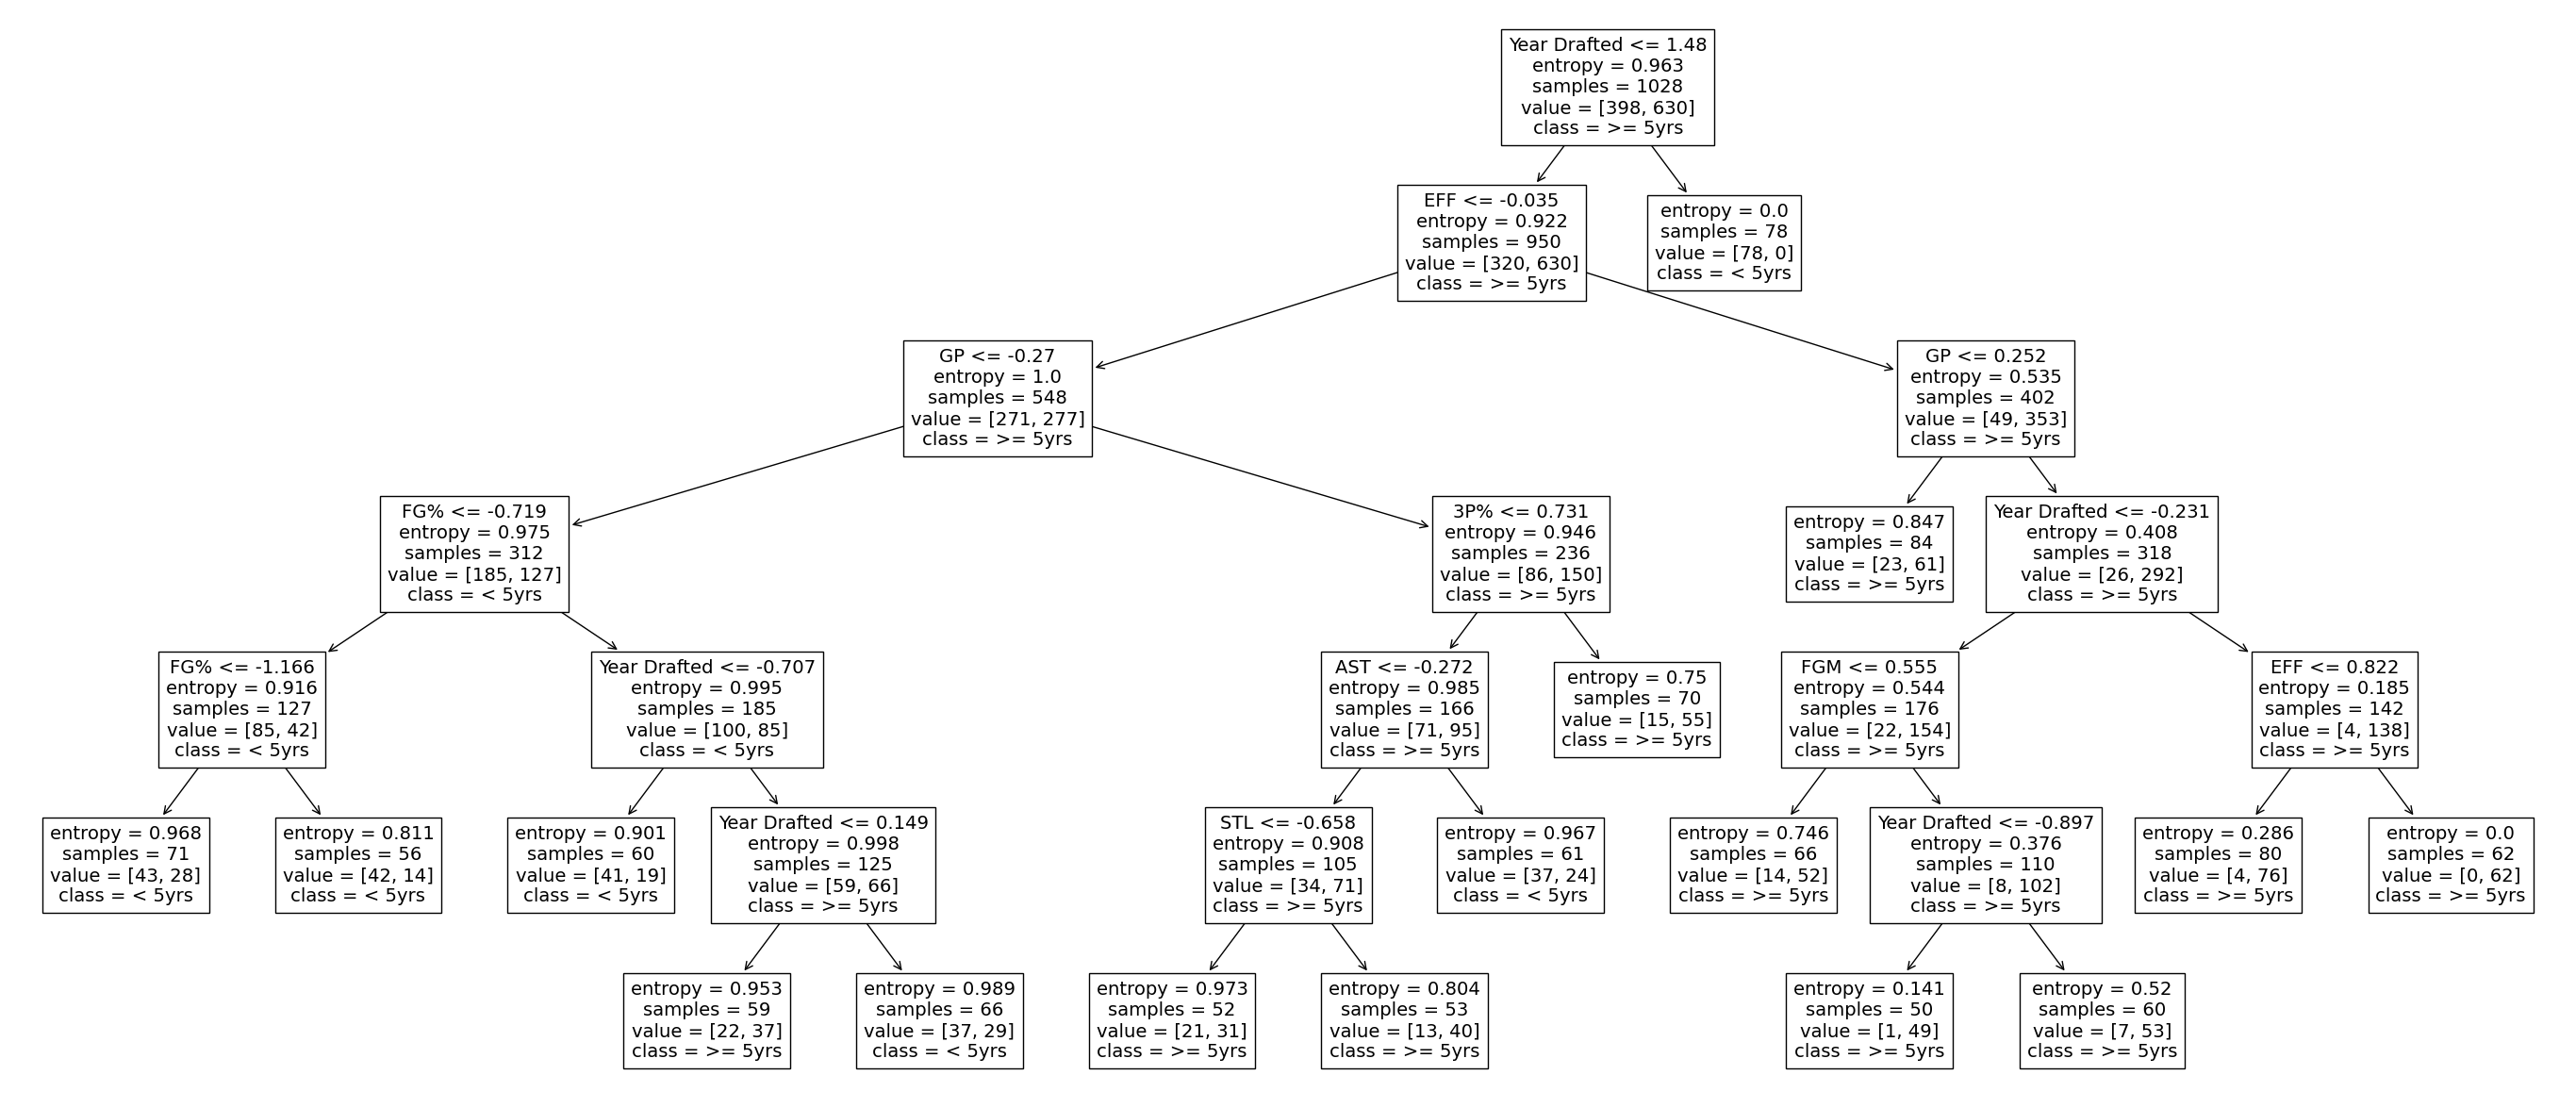

In [221]:
plt.figure(figsize=(35, 15))
_ = tree.plot_tree(dt_best, feature_names=data.drop('Yrs', axis=1).columns, class_names=['< 5yrs', '>= 5yrs'])
plt.savefig('dt.png')
plt.show()

### Find best hyperparameters for SVM

In [111]:
svm = SVC()

params_svm = {
    'C':[1.0, 0.75, 0.5, 0.1, 0.01, 0.001],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'probability':[True]
}

grid_search_svm = GridSearchCV(estimator=svm, param_grid=params_svm, cv=10, n_jobs=-1, scoring='f1')
grid_search_svm.fit(X_train, y_train)

svm_best = grid_search_svm.best_estimator_
svm_best

SVC(C=0.01, kernel='linear', probability=True)

In [112]:
svm_best.get_params()

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [222]:
print('min average f1 score for SVM: ', np.min(grid_search_svm.cv_results_['mean_test_score']))
print('max average f1 score for SVM: ', np.max(grid_search_svm.cv_results_['mean_test_score']))

min average f1 score for SVM:  0.6853489414084502
max average f1 score for SVM:  0.7720087691576069


### Find best hyperparameters for random forest

In [224]:
rf = RandomForestClassifier()

params_rf = {
    'n_estimators':[75, 100, 135, 165, 200], 
    'criterion':['gini', 'entropy'], 
    'max_depth':[10, 15, 20, 30, 40, None], 
    'min_samples_split':[2, 10, 50, 100], 
    'min_samples_leaf':[1, 10, 20, 50, 100]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=10, n_jobs=-1, scoring='f1')
grid_search_rf.fit(X_train, y_train)

rf_best = grid_search_rf.best_estimator_
rf_best

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=135)

In [225]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 135,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [226]:
print('min average f1 score for RF: ', np.min(grid_search_rf.cv_results_['mean_test_score']))
print('max average f1 score for RF: ', np.max(grid_search_rf.cv_results_['mean_test_score']))

min average f1 score for RF:  0.750944644983625
max average f1 score for RF:  0.7983320492718795


### Evaluate models

In [227]:
def evaluate_model(model, X_test, y_test):
    model_pred = model.predict(X_test)

    model_stats = []
    model_stats.append(accuracy_score(y_test, model_pred))
    model_stats.append(precision_score(y_test, model_pred, labels=[0, 1], pos_label=1))
    model_stats.append(recall_score(y_test, model_pred, labels=[0, 1], pos_label=1))
    model_stats.append(f1_score(y_test, model_pred, labels=[0, 1], pos_label=1))

    prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, prob[:,1])
    model_stats.append(fpr)
    model_stats.append(tpr)
    model_stats.append(auc(fpr, tpr))

    model_stats.append(model_pred)
    return model_stats

def print_evaluation(model_stats):
    print('{label:<10} | '.format(label='Accuracy'), model_stats[0])
    print('{label:<10} | '.format(label='Precision'), model_stats[1])
    print('{label:<10} | '.format(label='Recall'), model_stats[2])
    print('{label:<10} | '.format(label='F1-Score'), model_stats[3])
    print('{label:<10} | '.format(label='AUC'), model_stats[6], '\n')


print('Logistic Regression: ')
lr_stats = evaluate_model(lr_best, X_test, y_test)
print_evaluation(lr_stats)

print('Decision Tree: ')
dt_stats = evaluate_model(dt_best, X_test, y_test)
print_evaluation(dt_stats)

print('SVM: ')
svm_stats = evaluate_model(svm_best, X_test, y_test)
print_evaluation(svm_stats)

print('Random Forest: ')
rf_stats = evaluate_model(rf_best, X_test, y_test)
print_evaluation(rf_stats)

Logistic Regression: 
Accuracy   |  0.7120622568093385
Precision  |  0.7407407407407407
Recall     |  0.8484848484848485
F1-Score   |  0.7909604519774013
AUC        |  0.736429512516469 

Decision Tree: 
Accuracy   |  0.7120622568093385
Precision  |  0.7898089171974523
Recall     |  0.7515151515151515
F1-Score   |  0.7701863354037267
AUC        |  0.752733860342556 

SVM: 
Accuracy   |  0.7159533073929961
Precision  |  0.7473118279569892
Recall     |  0.8424242424242424
F1-Score   |  0.792022792022792
AUC        |  0.7288208168642951 

Random Forest: 
Accuracy   |  0.7587548638132295
Precision  |  0.7909604519774012
Recall     |  0.8484848484848485
F1-Score   |  0.8187134502923978
AUC        |  0.7971014492753623 



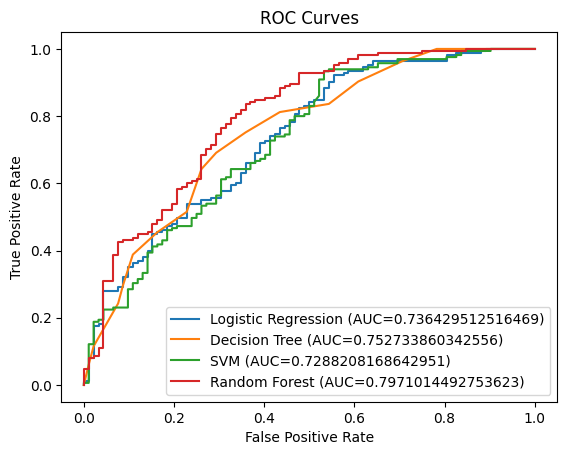

In [228]:
lr_auc = 'Logistic Regression (AUC=' + str(lr_stats[6]) + ')'
dt_auc = 'Decision Tree (AUC=' + str(dt_stats[6]) + ')'
svm_auc = 'SVM (AUC=' + str(svm_stats[6]) + ')'
rf_auc = 'Random Forest (AUC=' + str(rf_stats[6]) + ')'

plt.figure()
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(lr_stats[4], lr_stats[5], label=lr_auc)
plt.plot(dt_stats[4], dt_stats[5], label=dt_auc)
plt.plot(svm_stats[4], svm_stats[5], label=svm_auc)
plt.plot(rf_stats[4], rf_stats[5], label=rf_auc)
plt.legend()
plt.savefig('ROC.png')
plt.show()

In [143]:
lr_cm = confusion_matrix(y_test, lr_stats[7])
print('Logistic Regression Confusion Matrix: ')
print(lr_cm)

dt_cm = confusion_matrix(y_test, dt_stats[7])
print('Decision Tree Confusion Matrix: ')
print(lr_cm)

svm_cm = confusion_matrix(y_test, svm_stats[7])
print('SVM Confusion Matrix: ')
print(svm_cm)

rf_cm = confusion_matrix(y_test, rf_stats[7])
print('Random Forest Confusion Matrix: ')
print(rf_cm)

Logistic Regression Confusion Matrix: 
[[ 43  49]
 [ 25 140]]
Decision Tree Confusion Matrix: 
[[ 43  49]
 [ 25 140]]
SVM Confusion Matrix: 
[[ 45  47]
 [ 26 139]]
Random Forest Confusion Matrix: 
[[ 61  31]
 [ 31 134]]


In [240]:
print(np.arange(0.1, 1, 0.1))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


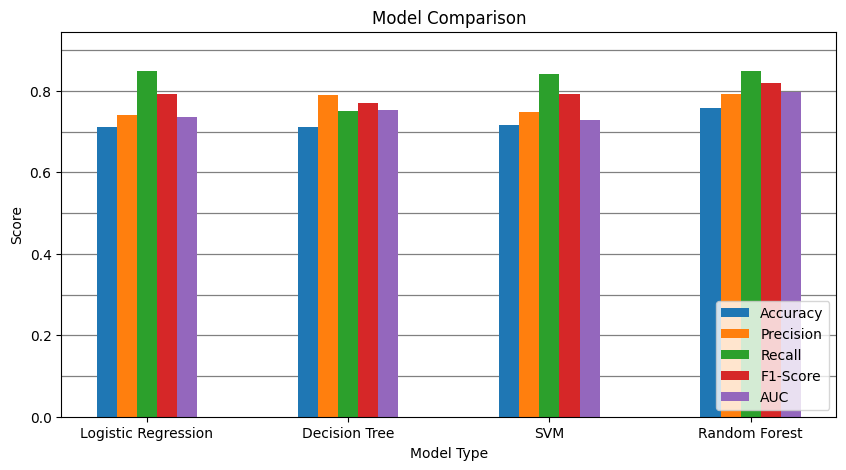

In [247]:
plt.figure(figsize=(10, 5))
plt.title('Model Comparison')
plt.xlabel('Model Type')
plt.ylabel('Score')
plt.bar(np.arange(4), [lr_stats[0], dt_stats[0], svm_stats[0], rf_stats[0]], label='Accuracy', width=0.1)
plt.bar(np.arange(4)+0.1, [lr_stats[1], dt_stats[1], svm_stats[1], rf_stats[1]], label='Precision', width=0.1)
plt.bar(np.arange(4)+0.2, [lr_stats[2], dt_stats[2], svm_stats[2], rf_stats[2]], label='Recall', width=0.1)
plt.bar(np.arange(4)+0.3, [lr_stats[3], dt_stats[3], svm_stats[3], rf_stats[3]], label='F1-Score', width=0.1)
plt.bar(np.arange(4)+0.4, [lr_stats[6], dt_stats[6], svm_stats[6], rf_stats[6]], label='AUC', width=0.1)
plt.legend(loc='lower right')
plt.xticks(np.arange(4) + 0.2, ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest'])
for i in np.arange(0.1, 1, 0.1):
    plt.axhline(y=i, color='gray', zorder=0.0, linewidth=0.9)
plt.savefig('model_comparison.png')
plt.show()

### Feature Importance

In [144]:
rf_best.feature_importances_

array([0.13634776, 0.12247595, 0.05612889, 0.04662308, 0.04636011,
       0.0378713 , 0.05857712, 0.01520921, 0.02396614, 0.03387304,
       0.03603404, 0.03890016, 0.04344933, 0.03657416, 0.03952484,
       0.04447142, 0.03017272, 0.02184367, 0.02304372, 0.02592552,
       0.08262782])

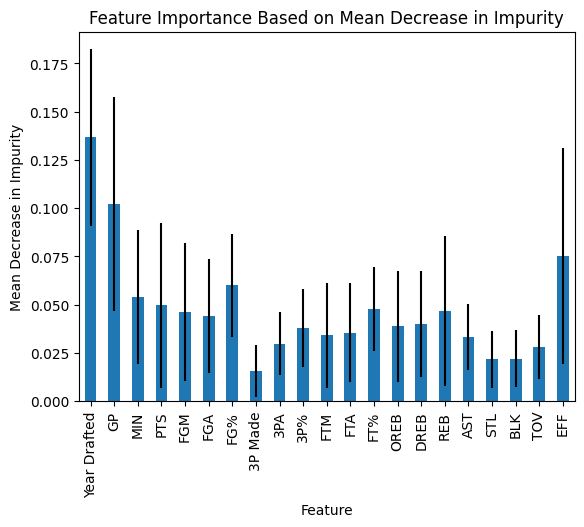

In [230]:
columns = list(data.columns)
columns.pop()
importances = pd.Series(rf_best.feature_importances_, index=columns)
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

fig, ax = plt.subplots()
ax.set_title('Feature Importance Based on Mean Decrease in Impurity')
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Decrease in Impurity')
importances.plot.bar(yerr=std, ax=ax)
plt.savefig('feature_importance.png')

### Tested random forest model that doesn't look at three point stats, but performance didn't increase

In [188]:
data_wo_threes = data.copy()
data_wo_threes = data.drop(['3P Made', '3PA', '3P%'], axis=1)
data_wo_threes

,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,Yrs
0,2016,36,27.4,7.4,2.6,7.6,34.7,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,7.3,0
1,2016,35,26.9,7.2,2.0,6.7,29.6,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,7.9,0
2,2016,30,25.7,5.8,2.1,5.3,40.0,0.7,1.0,72.4,1.5,2.0,3.5,1.5,0.7,0.3,0.7,7.5,0
3,2016,32,22.9,8.3,3.2,6.9,46.2,0.9,1.1,85.7,0.4,2.1,2.5,3.6,1.0,0.1,1.5,10.1,0
4,2016,33,22.8,5.2,1.9,4.6,40.5,0.6,0.8,76.0,0.7,2.2,2.8,1.0,0.6,0.3,0.7,6.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1980,59,10.1,3.2,1.4,3.1,45.4,0.4,0.7,56.4,0.5,0.6,1.0,1.2,0.6,0.1,1.3,2.8,0
1281,1980,47,9.6,2.0,0.7,2.0,35.8,0.5,0.7,78.1,0.2,0.7,0.9,1.5,0.5,0.0,0.6,2.9,1
1282,1980,60,8.9,2.8,1.0,3.0,33.0,0.9,1.2,73.9,0.5,0.7,1.2,1.3,0.4,0.0,0.6,2.7,0
1283,1980,55,8.4,2.7,1.0,2.5,41.2,0.7,1.5,43.5,0.5,1.2,1.7,0.3,0.4,0.4,0.6,2.6,0


In [189]:
X_wo_threes = data_wo_threes.drop('Yrs', axis=1)
Y_wo_threes = data_wo_threes.Yrs

X_train_wo_threes, X_test_wo_threes, y_train_wo_threes, y_test_wo_threes = train_test_split(X_wo_threes, Y_wo_threes, test_size=0.2)

scaler_wo_threes = StandardScaler().fit(X_train_wo_threes)
X_train_wo_threes = scaler_wo_threes.transform(X_train_wo_threes)
X_test_wo_threes = scaler_wo_threes.transform(X_test_wo_threes)

print_correlation(data_wo_threes)

   Column    |     Correlation      |         P-Value         
Year Drafted | -0.1400660126640122  |  4.633139272943828e-07
GP           | 0.3911947281748093   |  3.0181966394803226e-48
MIN          | 0.3109098046749413   |  3.381136514696802e-30
PTS          | 0.30979923955374455  |  5.534927199988265e-30
FGM          | 0.31122312370600724  |  2.9410872965635354e-30
FGA          | 0.2857387811621094   |  1.4416068254192578e-25
FG%          | 0.21935362075136491  |  1.827260733040309e-15
FTM          | 0.2913043805629553   |  1.494908731261937e-26
FTA          | 0.2901330845060283   |  2.4187247858203797e-26
FT%          | 0.10566483975527832  |  0.00014782342492115062
OREB         | 0.28547808317040224  |  1.6010634671213757e-25
DREB         | 0.28220010066979534  |  5.931842916576116e-25
REB          | 0.2952883026865382   |  2.860652819411771e-27
AST          | 0.17073048206106042  |  7.298514785076642e-10
STL          | 0.22634228059490083  |  2.164862483276862e-16
BLK          | 0

In [190]:
rf_wo_threes = RandomForestClassifier()

params_rf_wo_threes = {
    'n_estimators':[75, 100, 135, 165, 200], 
    'criterion':['gini', 'entropy'], 
    'max_depth':[10, 15, 20, 30, 40, None], 
    'min_samples_split':[2, 10, 50, 100], 
    'min_samples_leaf':[1, 10, 20, 50, 100]
}

grid_search_rf_wo_threes = GridSearchCV(estimator=rf_wo_threes, param_grid=params_rf_wo_threes, cv=10, n_jobs=-1, scoring='f1')
grid_search_rf_wo_threes.fit(X_train_wo_threes, y_train_wo_threes)

rf_wo_threes_best = grid_search_rf_wo_threes.best_estimator_
rf_wo_threes_best

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       n_estimators=200)

In [191]:
rf_wo_threes_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [195]:
rf_wo_threes_stats = evaluate_model(rf_wo_threes_best, X_test_wo_threes, y_test_wo_threes)

print('Random Forest Model Without 3 Point Stats: ')
print_evaluation(rf_wo_threes_stats)

Random Forest Model Without 3 Point Stats: 
Accuracy   |  0.7509727626459144
Precision  |  0.7294117647058823
Recall     |  0.8732394366197183
F1-Score   |  0.7948717948717949
AUC        |  0.8083282302510717 

